In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions_configs import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

import PyMieScatt as pms
from analyzing_functions import *

seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Load models

In [2]:
model_name_iv = 'forward_model/surrogate_model'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_iv1_F11/models'

model_name_fw = 'forward_model/surrogate_model'
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw1_F11/models'
plot_dir= '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw1_F11/plots_meas'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [3]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

In [4]:
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)


# Load data

In [5]:
# measurement data  - need to be divided by (4*np.pi)
#meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5'
#dvar_meas = pd.read_hdf(meas_datafile,'dvar')
meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221219.h5'
dvar_meas = pd.read_hdf(meas_datafile,'param')

qoi_meas = pd.read_hdf(meas_datafile,'qoi')

qoi_meas



F11_0.532_10 F11_0.532_11 F11_0.532_12 F11_0.532_13 F11_0.532_14  \
0     10.239827    10.194808    10.145547    10.092117    10.034599   
1     326.86447    321.21155    315.10266    308.56677    301.63461   
2     160.12137    156.38988    152.37726    148.10745    143.60559   
3     249.96579    237.15302     223.7457    209.90463    195.79099   
4     235.75613    211.91342    187.91399    164.21085     141.2289   
5     11.752591    11.707408    11.657947    11.604275    11.546465   
6     30.748764    30.595501    30.427883    30.246176    30.050674   
7     75.704582    75.110214    74.462082    73.761749    73.010887   
8     158.11987    156.57832    154.89992    153.08939    151.15178   
9     128.23978    126.72509    125.07919    123.30756    121.41608   
10    262.51611     258.0994    253.32208    248.20578    242.77332   
11    196.29445    191.89273    187.15506    182.10863    176.78203   
12    379.23856    367.91727    355.81595     343.0239    329.63391   
13    137.42064    130.41521    123.07205    115.47595    107.71186   

   F11_0.532_15 F11_0.532_16 F11_0.532_17 F11_0.532_18 F11_0.532_19  ...  \
0      9.973075     9.898133     9.812126     9.780692     9.713143  ...   
1     294.33823   274.810342   273.276961   267.670406    256.42997  ...   
2     138.89772   147.105122    133.24079   114.931483   109.322211  ...   
3     181.56351   157.498141    131.03587   101.940804    72.543582  ...   
4     119.35442    71.961964    57.870742    49.497148    41.000065  ...   
5     11.484595    11.318596    11.203328    11.143059    11.132492  ...   
6     29.841686    29.746688     29.56951    29.268835    28.897714  ...   
7     72.211281    65.265902    64.064075    63.030589    62.087433  ...   
8      149.0925   139.418343   136.915128   135.413765   133.908431  ...   
9     119.41093   114.638491   112.756318    110.20757   107.400512  ...   
10    237.04869    213.72616    209.10027   206.119219   200.170367  ...   
11    171.20494   158.477975   153.810887   146.616963   139.183722  ...   
12    315.74103   292.228769   284.521563   260.474723    240.43224  ...   
13    99.863449    94.076989    90.692855    81.414035    68.016267  ...   

   PPF_0.532_161 PPF_0.532_162 PPF_0.532_163 PPF_0.532_164 PPF_0.532_165  \
0       0.061826      0.057134      0.052089      0.040751      0.040911   
1      -0.441232     -0.401337     -0.368562     -0.334364     -0.309479   
2      -0.741377     -0.693725     -0.681174     -0.632558     -0.602007   
3      -0.575589     -0.536714     -0.507962     -0.553993     -0.525728   
4      -0.523141      -0.50454     -0.472679     -0.416469     -0.317612   
5       0.081484      0.078445      0.070497       0.06563      0.061137   
6       0.152212      0.129584      0.104234      0.093521      0.085057   
7      -0.066784     -0.085836     -0.094277     -0.059041     -0.053655   
8       0.020547      0.022647      0.022047      0.016791       0.03127   
9       0.250642      0.212366      0.177127      0.172673      0.174824   
10     -0.093295     -0.077207     -0.074237     -0.087953     -0.076371   
11      0.002308      0.013184      0.001364      -0.03792     -0.012979   
12      0.136368      0.122509      0.104022      0.090523      0.108632   
13      0.055255     -0.011847     -0.014415      0.085851     -0.048677   

   PPF_0.532_166 PPF_0.532_167 PPF_0.532_168 PPF_0.532_169 PPF_0.532_170  
0       0.044564      0.038592      0.033057      0.027956      0.023287  
1      -0.249522     -0.216496     -0.185668     -0.157119     -0.130907  
2      -0.396607     -0.344951      -0.29593     -0.250108     -0.207876  
3      -0.412606     -0.357914     -0.305482     -0.256474     -0.211591  
4      -0.356307     -0.296748     -0.241971     -0.193755     -0.152567  
5       0.037566      0.032521      0.027848      0.023544      0.019608  
6       0.064963      0.056329      0.048305      0.040894      0.034097  
7      -0.094474     -0.082034     -0.070424     -0.059

In [6]:
# Pymiescatt simulation of dvar_meas - truncated angles need to be removed
qoi_meas_pymiescatt = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='qoi')
qoi_meas_pymiescatt

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [7]:
# Processed version of qoi_meas - need to be divided by (4*np.pi)
#qoi_meas_preprocessed = pd.read_csv('/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_qoi.txt')

#qoi_meas_preprocessed = qoi_meas_preprocessed.drop(['Unnamed: 0'], axis = 1)
#qoi_meas_preprocessed


meas_datafile_preprocessed = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221220.h5'
dvar_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'param')

qoi_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'qoi')
qoi_meas_preprocessed

F11_0.532_10 F11_0.532_11 F11_0.532_12 F11_0.532_13 F11_0.532_14  \
0     10.239827    10.194808    10.145547    10.092117    10.034599   
1     326.86447    321.21155    315.10266    308.56677    301.63461   
2     160.12137    156.38988    152.37726    148.10745    143.60559   
3     249.96579    237.15302     223.7457    209.90463    195.79099   
4     235.75613    211.91342    187.91399    164.21085     141.2289   
5     11.752591    11.707408    11.657947    11.604275    11.546465   
6     30.748764    30.595501    30.427883    30.246176    30.050674   
7     75.704582    75.110214    74.462082    73.761749    73.010887   
8     158.11987    156.57832    154.89992    153.08939    151.15178   
9     128.23978    126.72509    125.07919    123.30756    121.41608   
10    262.51611     258.0994    253.32208    248.20578    242.77332   
11    196.29445    191.89273    187.15506    182.10863    176.78203   
12    379.23856    367.91727    355.81595     343.0239    329.63391   
13    137.42064    130.41521    123.07205    115.47595    107.71186   

   F11_0.532_15 F11_0.532_16 F11_0.532_17 F11_0.532_18 F11_0.532_19  ...  \
0      9.973075     9.907636     9.838376     9.765396     9.688802  ...   
1     294.33823    286.71097    278.78708    270.60162    262.19009  ...   
2     138.89772    134.01062    128.97156    123.80804    118.54761  ...   
3     181.56351    167.37581    153.37401    139.69453    126.46206  ...   
4     119.35442    98.925941     80.22715    63.481689    48.849827  ...   
5     11.484595    11.418749    11.349015    11.275488    11.198265  ...   
6     29.841686    29.619547    29.384605    29.137228    28.877802  ...   
7     72.211281    71.364807     70.47345    69.539268    68.564407  ...   
8      149.0925    146.91719    144.63177    142.24245    139.75555  ...   
9     119.41093    117.29861    115.08589    112.77979     110.3875  ...   
10    237.04869    231.05679     224.8233    218.37454    211.73721  ...   
11    171.20494    165.40796    159.42224    153.27936    147.01094  ...   
12    315.74103    301.44171    286.83267    272.00998    257.06799  ...   
13    99.863449    92.011734    84.233818    76.601868    69.181999  ...   

   PPF_0.532_161 PPF_0.532_162 PPF_0.532_163 PPF_0.532_164 PPF_0.532_165  \
0       0.081034      0.072851      0.065115      0.057823      0.050974   
1      -0.442524     -0.400883     -0.360518     -0.321694     -0.284636   
2      -0.660275     -0.611036     -0.558628     -0.504535      -0.45013   
3      -0.638159     -0.609828      -0.56966     -0.521175     -0.467822   
4      -0.580507     -0.558302     -0.522558     -0.474301     -0.417153   
5       0.068454      0.061512      0.054955       0.04878      0.042984   
6       0.117186      0.105547      0.094501      0.084052      0.074205   
7      -0.167922     -0.151881     -0.136464     -0.121726     -0.107716   
8       0.011969      0.013367      0.014146      0.014395        0.0142   
9       0.192151      0.175165      0.158521      0.142335      0.126713   
10     -0.087538     -0.083462     -0.078723     -0.073427     -0.067688   
11     -0.050779     -0.041434     -0.032962     -0.025375     -0.018693   
12      0.166831      0.153275      0.139661      0.126198      0.113069   
13      0.040776       0.05445      0.071118       0.09077        0.1131   

   PPF_0.532_166 PPF_0.532_167 PPF_0.532_168 PPF_0.532_169 PPF_0.532_170  
0       0.044564      0.038592      0.033057      0.027956      0.023287  
1      -0.249522     -0.216496     -0.185668     -0.157119     -0.130907  
2      -0.396607     -0.344951      -0.29593     -0.250108     -0.207876  
3      -0.412606     -0.357914     -0.305482     -0.256474     -0.211591  
4      -0.356307     -0.296748     -0.241971     -0.193755     -0.152567  
5       0.037566      0.032521      0.027848      0.023544      0.019608  
6       0.064963      0.056329      0.048305      0.040894      0.034097  
7      -0.094474     -0.082034     -0.070424     -0.059

# Apply logarithm and other preprocessing of data

In [8]:
qoi_meas_pymiescatt
#qoi_meas_preprocessed

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [9]:
F11_columns_meas = [x for x in qoi_meas.columns if 'F11' in x]
F11_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'F11' in x]
PPF_columns_meas = [x for x in qoi_meas.columns if 'PPF' in x]
PPF_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'PPF' in x]

In [10]:
qoi_meas[F11_columns_meas] = np.log(qoi_meas[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_preprocessed[F11_columns_meas] = np.log(qoi_meas_preprocessed[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_pymiescatt[F11_columns_pms] = np.log(qoi_meas_pymiescatt[F11_columns_pms].astype('float64'))


In [11]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles = np.concatenate([angles1, angles2])
F11_list = []
PPF_list = []
for angle in angles:
    F11_list.append('F11_'+str(angle))
    PPF_list.append('PPF_'+str(angle))
qoi_col_list = np.concatenate([np.array(F11_list),np.array(PPF_list)])

In [12]:
qoi_meas_pymiescatt = qoi_meas_pymiescatt[qoi_col_list]

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)
for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements.jpg')


Error in callback <function flush_figures at 0x2b07c5d20160> (for post_execute):


KeyboardInterrupt: 

In [14]:
qoi_meas

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.238678     -0.247405     -0.250614     -0.257544  ...   
1       3.153705      3.085057      3.079462      3.058732      3.015831  ...   
2       2.402714      2.460123      2.361134      2.213312      2.163275  ...   
3       2.670581      2.528389      2.344447      2.093368      1.753163  ...   
4       2.251073      1.745113      1.527188      1.370891      1.182549  ...   
5      -0.090018     -0.104577     -0.114813     -0.120207     -0.121156  ...   
6       0.864882      0.861694      0.855720      0.845499      0.832738  ...   
7       1.748572      1.647445      1.628860      1.612596      1.597519  ...   
8       2.473543      2.406455      2.388337      2.377311      2.366132  ...   
9       2.251546      2.210759      2.194205      2.171341      2.145541  ...   
10      2.937241      2.833671      2.811790      2.797430      2.768145  ...   
11      2.611837      2.534591      2.504700      2.456799      2.404771  ...   
12      3.223898      3.146513      3.119785      3.031482      2.951414  ...   
13      2.072779      2.013089      1.976454      1.868523      1.688723  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141       -0.50454      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497        0.06563       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791        0.03127   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364       -0.03792      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

In [15]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.237719     -0.244734     -0.252179     -0.260053  ...   
1       3.153705      3.127450      3.099424      3.069623      3.038046  ...   
2       2.402714      2.366895      2.328568      2.287708      2.244290  ...   
3       2.670581      2.589217      2.501855      2.408434      2.308918  ...   
4       2.251073      2.063347      1.853838      1.619727      1.357727  ...   
5      -0.090018     -0.095768     -0.101893     -0.108393     -0.115265  ...   
6       0.864882      0.857410      0.849447      0.840992      0.832049  ...   
7       1.748572      1.736781      1.724212      1.710867      1.696749  ...   
8       2.473543      2.458845      2.443167      2.426509      2.408871  ...   
9       2.251546      2.233699      2.214654      2.194413      2.172973  ...   
10      2.937241      2.911639      2.884291      2.855187      2.824322  ...   
11      2.611837      2.577391      2.540532      2.501238      2.459483  ...   
12      3.223898      3.177552      3.127875      3.074815      3.018316  ...   
13      2.072779      1.990892      1.902572      1.807597      1.705716  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.081034       0.072851       0.065115       0.057823       0.050974   
1       -0.442524      -0.400883      -0.360518      -0.321694      -0.284636   
2       -0.660275      -0.611036      -0.558628      -0.504535       -0.45013   
3       -0.638159      -0.609828       -0.56966      -0.521175      -0.467822   
4       -0.580507      -0.558302      -0.522558      -0.474301      -0.417153   
5        0.068454       0.061512       0.054955        0.04878       0.042984   
6        0.117186       0.105547       0.094501       0.084052       0.074205   
7       -0.167922      -0.151881      -0.136464      -0.121726      -0.107716   
8        0.011969       0.013367       0.014146       0.014395         0.0142   
9        0.192151       0.175165       0.158521       0.142335       0.126713   
10      -0.087538      -0.083462      -0.078723      -0.073427      -0.067688   
11      -0.050779      -0.041434      -0.032962      -0.025375      -0.018693   
12       0.166831       0.153275       0.139661       0.126198       0.113069   
13       0.040776        0.05445       0.071118        0.09077         0.1131   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

In [16]:
qoi_meas_pymiescatt

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.330722 -0.335406 -0.340532 -0.346100 -0.352109 -0.358556 -0.365442   
1   3.279742  3.262431  3.243463  3.222838  3.200552  3.176605  3.150995   
2   2.681297  2.656183  2.628618  2.598585  2.566067  2.531043  2.493492   
3   3.316615  3.261761  3.201326  3.135219  3.063343  2.985599  2.901892   
4   2.626295  2.509020  2.377339  2.230161  2.066209  1.884021  1.681980   
5  -0.126536 -0.130674 -0.135202 -0.140119 -0.145425 -0.151117 -0.157195   
6   1.057597  1.052010  1.045895  1.039251  1.032082  1.024387  1.016169   
7   1.647584  1.639660  1.630986  1.621563  1.611393  1.600476  1.588815   
8   2.512474  2.502008  2.490545  2.478086  2.464630  2.450179  2.434731   
9   2.191082  2.179161  2.166100  2.151899  2.136556  2.120069  2.102438   
10  2.817757  2.801281  2.783222  2.763577  2.742340  2.719508  2.695075   
11  2.576809  2.554683  2.530408  2.503972  2.475362  2.444564  2.411563   
12  3.176521  3.147132  3.114848  3.079640  3.041478  3.000329  2.956156   
13  2.287451  2.235916  2.179083  2.116835  2.049042  1.975553  1.896204   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  -0.372765 -0.380522 -0.388714  ...  0.075290  0.067477  0.060104  0.053171   
1   3.123719  3.094777  3.064166  ... -0.426074 -0.384111 -0.343685 -0.305037   
2   2.453391  2.410716  2.365439  ... -0.638724 -0.584372 -0.528777 -0.473179   
3   2.812132  2.716245  2.614180  ... -0.659852 -0.611053 -0.555606 -0.496657   
4   1.458435  1.212017  0.942395  ... -0.690478 -0.659288 -0.610779 -0.549424   
5  -0.163656 -0.170499 -0.177722  ...  0.064931  0.058182  0.051817  0.045832   
6   1.007428  0.998166  0.988385  ...  0.105330  0.094565  0.084371  0.074750   
7   1.576411  1.563266  1.549383  ... -0.108208 -0.095673 -0.084043 -0.073306   
8   2.418287  2.400848  2.382413  ...  0.047522  0.044453  0.041145  0.037672   
9   2.083660  2.063735  2.042660  ...  0.165475  0.150214  0.135351  0.120977   
10  2.669038  2.641389  2.612124  ... -0.001929 -0.003679 -0.004958 -0.005815   
11  2.376343  2.338885  2.299171  ... -0.171137 -0.153189 -0.135917 -0.119461   
12  2.908920  2.858577  2.805079  ...  0.218257  0.202657  0.186377  0.169658   
13  1.810808  1.719155  1.621013  ...  0.119823  0.123663  0.124947  0.123646   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.046673  0.040608  0.034975  0.029769  0.024990  0.020634  
1  -0.268364 -0.233820 -0.201520 -0.171547 -0.143958 -0.118788  
2  -0.418641 -0.366030 -0.316024 -0.269131 -0.225709 -0.185992  
3  -0.436943 -0.378629 -0.323275 -0.271903 -0.225094 -0.183102  
4  -0.480965 -0.410948 -0.343714 -0.282059 -0.227385 -0.180077  
5   0.040226  0.034994  0.030136  0.025648  0.021529  0.017775  
6   0.065706  0.057241  0.049357  0.042055  0.035337  0.029202  
7  -0.063444 -0.054432 -0.046241 -0.038838 -0.032189 -0.026258  
8   0.034104  0.030503  0.026928  0.023431  0.020058  0.016851  
9   0.107174  0.094014  0.081560  0.069867  0.058980  0.048939  
10 -0.006301 -0.006468 -0.006367 -0.006051 -0.005569 -0.004967  
11 -0.103941 -0.089454 -0.076073 -0.063843 -0.052787 -0.042903  
12  0.152746  0.135886  0.119318  0.103261  0.087918  0.073464  
13  0.119858  0.113797  0.105778  0.096195  0.085485  0.074104  

[14 rows x 304 columns]

# Make predictions with the forward model fw
## from phase functions to aerosol properties

In [18]:
# prediction of measurement data
dvar_meas_pred = surr_fw.predict(qoi_meas[F11_columns_meas].values)
dvar_meas_pred = pd.DataFrame(data =dvar_meas_pred, columns = dvar_meas.columns)
dvar_meas_pred_2qoi = dvar_meas_pred.copy()
dvar_meas_pred = np.exp(dvar_meas_pred)
dvar_meas_pred['GSD']=dvar_meas_pred['GSD']+1
dvar_meas_pred['n']=dvar_meas_pred['n']+1.33
dvar_meas_pred['RmedianV'] = dvar_meas_pred['RmedianV']*1e-3 # in um
dvar_meas_pred.to_csv(f'{plot_dir}/dvar_meas_pred.csv')
dvar_meas_pred

Vtot  RmedianV       GSD         n         k
0    0.946811  0.125347  1.028075  1.361148  0.069900
1    6.095434  0.212675  1.048359  2.054068  0.043660
2    2.228089  0.288940  1.094056  1.460429  0.033650
3    4.653403  0.474287  1.111767  1.927755  0.006701
4   11.580082  0.557726  1.154163  1.574684  0.000477
5    0.231346  0.103134  1.041125  2.030824  0.006170
6    1.898763  0.126302  1.036506  1.453122  0.076249
7    4.017063  0.161523  1.047777  1.512285  0.265213
8    8.491000  0.183904  1.065745  1.371176  0.227007
9    3.330108  0.187980  1.063949  1.632791  0.269469
10   5.530057  0.254080  1.065173  1.649843  0.277892
11   2.504287  0.237194  1.080270  1.643304  0.105024
12   7.191220  0.312812  1.083815  2.048034  0.161226
13   2.835701  0.371094  1.163560  1.883979  0.166406

In [19]:
dvar_meas_pred_2qoi

Vtot  RmedianV       GSD         n         k
0  -0.054656  4.831084 -3.572864 -3.469011 -2.660694
1   1.807540  5.359767 -3.029106 -0.322870 -3.131333
2   0.801144  5.666218 -2.363865 -2.036929 -3.391739
3   1.537599  6.161812 -2.191342 -0.514575 -5.005427
4   2.449287  6.323867 -1.869743 -1.407789 -7.648342
5  -1.463841  4.636031 -3.191136 -0.355498 -5.088000
6   0.641203  4.838679 -3.310270 -2.094582 -2.573754
7   1.390551  5.084647 -3.041215 -1.702183 -1.327223
8   2.139007  5.214412 -2.721971 -3.189899 -1.482772
9   1.203005  5.236335 -2.749669 -1.194713 -1.311303
10  1.710198  5.537649 -2.730706 -1.139924 -1.280522
11  0.918004  5.468878 -2.522358 -1.160582 -2.253563
12  1.972861  5.745602 -2.479139 -0.331239 -1.824951
13  1.042289  5.916456 -1.810575 -0.590629 -1.793326

In [20]:
# prediction of processed measurement data
dvar_meas_preprocessed_pred = surr_fw.predict(qoi_meas_preprocessed[F11_columns_meas].values)
dvar_meas_preprocessed_pred = pd.DataFrame(data =dvar_meas_preprocessed_pred, columns = dvar_meas.columns)
dvar_meas_preprocessed_pred_2qoi = dvar_meas_preprocessed_pred.copy()
dvar_meas_preprocessed_pred = np.exp(dvar_meas_preprocessed_pred)
dvar_meas_preprocessed_pred['GSD']=dvar_meas_preprocessed_pred['GSD']+1
dvar_meas_preprocessed_pred['n']=dvar_meas_preprocessed_pred['n']+1.33
dvar_meas_preprocessed_pred['RmedianV'] = dvar_meas_preprocessed_pred['RmedianV']*1e-3 # in um
dvar_meas_preprocessed_pred.to_csv(f'{plot_dir}/dvar_meas_preprocessed_pred.csv')
dvar_meas_preprocessed_pred

Vtot  RmedianV       GSD         n         k
0    0.952293  0.123177  1.026529  1.357806  0.055245
1    6.036147  0.205135  1.045875  2.099401  0.040366
2    2.468247  0.289155  1.087261  1.454677  0.048026
3    4.818755  0.366827  1.046285  1.923956  0.013574
4   24.207881  0.483314  1.102478  1.568928  0.001561
5    0.232541  0.099949  1.046817  2.021741  0.005225
6    2.003979  0.126440  1.034900  1.438622  0.073094
7    2.679402  0.158080  1.076914  1.526016  0.191365
8    6.969744  0.178306  1.071493  1.385020  0.305297
9    3.455513  0.188864  1.071819  1.695338  0.275175
10   5.858809  0.251122  1.062343  1.760639  0.265392
11   2.633338  0.243872  1.076484  1.676125  0.114392
12   7.967213  0.309345  1.078145  1.941288  0.181068
13   2.728080  0.324200  1.093659  1.748726  0.254692

In [21]:
F11_columns = [x for x in qoi_meas_pymiescatt.columns if 'F11' in x]

In [22]:
# prediction of with pymiescatt predicted measurement data
dvar_meas_pymiescatt_pred = surr_fw.predict(qoi_meas_pymiescatt[F11_columns].values)
dvar_meas_pymiescatt_pred = pd.DataFrame(data =dvar_meas_pymiescatt_pred, columns = dvar_meas.columns)
dvar_meas_pymiescatt_pred_2qoi = dvar_meas_pymiescatt_pred.copy()

dvar_meas_pymiescatt_pred = np.exp(dvar_meas_pymiescatt_pred)
dvar_meas_pymiescatt_pred['GSD']=dvar_meas_pymiescatt_pred['GSD']+1
dvar_meas_pymiescatt_pred['n']=dvar_meas_pymiescatt_pred['n']+1.33
dvar_meas_pymiescatt_pred['RmedianV'] = dvar_meas_pymiescatt_pred['RmedianV']*1e-3 # in um
dvar_meas_pymiescatt_pred.to_csv(f'{plot_dir}/dvar_meas_pymiescatt_pred.csv')
dvar_meas_pymiescatt_pred

Vtot  RmedianV       GSD         n         k
0    0.758974  0.124528  1.018719  1.359823  0.051720
1    5.680365  0.196341  1.040077  1.817463  0.068474
2    1.848216  0.260681  1.077671  1.464313  0.005946
3    7.447598  0.411985  1.054720  2.368473  0.006825
4   40.511548  0.799765  1.234190  1.363782  0.001911
5    0.266998  0.106735  1.022625  1.958281  0.014271
6    1.991843  0.124156  1.053014  1.537950  0.115970
7    2.378686  0.185522  1.070373  1.503410  0.213755
8    5.282439  0.181192  1.060861  1.423069  0.287303
9    2.330818  0.182198  1.053195  1.519780  0.046698
10   4.819689  0.261775  1.056141  1.602707  0.159998
11   2.347621  0.234190  1.110165  1.584263  0.109054
12   7.103958  0.271827  1.103939  2.196486  0.336623
13   2.728025  0.400602  1.075331  6.018341  0.091841

# Make predictions with the forward model iv
## from aerosol properties to phase functions

In [23]:
dvar_meas_2qoi = dvar_meas.copy()
dvar_meas_2qoi['RmedianV']= dvar_meas_2qoi['RmedianV']*1e3
dvar_meas_2qoi['GSD']= dvar_meas_2qoi['GSD']-1
dvar_meas_2qoi['n']= dvar_meas_2qoi['n']-1.33
dvar_meas_2qoi = np.log(dvar_meas_2qoi.astype('float64'))
dvar_meas_2qoi


Vtot  RmedianV       GSD         n         k
0  -0.170104  4.609785 -3.218876 -1.347074 -9.210340
1   1.130124  5.528602 -2.995732 -1.347074 -9.210340
2   0.316112  5.710924 -2.995732 -1.347074 -9.210340
3   1.259201  5.998606 -2.995732 -1.347074 -9.210340
4   1.560907  6.221750 -2.995732 -1.347074 -9.210340
5   0.797529  4.339768 -2.407946 -1.237874 -1.500584
6   0.733104  4.767212 -2.407946 -1.237874 -1.500584
7   0.764918  5.028404 -2.525729 -1.237874 -1.500584
8   1.354122  5.182555 -2.525729 -1.237874 -1.500584
9   0.901635  5.260757 -2.659260 -1.237874 -1.500584
10  1.327906  5.433869 -2.525729 -1.237874 -1.500584
11  0.973193  5.578451 -2.525729 -1.237874 -1.500584
12  1.529973  5.717516 -2.659260 -1.237874 -1.500584
13  0.708613  5.986968 -2.302585 -1.237874 -1.500584

In [24]:
F11_columns

['F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_85',
 'F11_95',
 'F11_96',
 'F11_97',
 'F11_98',
 'F11_99',
 'F11_100',
 'F11_101',
 'F11_102',
 'F11_103',
 'F11_104',
 'F11_105',
 'F11_106',
 'F11_107',
 'F11_108',
 

In [25]:
# qoi: prediction of true data
qoi_pred = surr_iv.predict(dvar_meas_2qoi)
qoi_pred = pd.DataFrame(qoi_pred, columns = F11_columns)
qoi_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_pred


F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   1.556244  1.495488  1.524061  1.603231  1.689868  1.639768  1.656927   
1   2.139572  2.336708  2.377896  2.391117  2.221307  2.248727  2.084717   
2   1.007729  1.148916  1.183412  1.214431  1.078177  1.112826  0.991797   
3   2.569990  2.627398  2.540692  2.459759  2.259333  2.242264  2.047023   
4   2.889732  2.898277  2.746552  2.567816  2.283338  2.153569  1.891584   
5  -0.057378 -0.068203 -0.052886 -0.077313  0.007313  0.041824  0.042624   
6   1.068838  1.075408  1.090044  1.089329  1.061880  1.049513  1.044367   
7   1.695042  1.693391  1.733802  1.705751  1.677694  1.672412  1.659335   
8   2.520439  2.497887  2.498866  2.472488  2.471898  2.439120  2.428934   
9   2.171505  2.140082  2.134445  2.109759  2.107404  2.076727  2.065854   
10  2.771515  2.754590  2.735689  2.720665  2.709393  2.677409  2.644861   
11  2.708322  2.684058  2.640426  2.619843  2.588519  2.562240  2.511324   
12  3.173678  3.149216  3.108834  3.081391  3.036054  3.000715  2.936964   
13  2.267795  2.224106  2.173869  2.124132  2.051717  1.967306  1.862185   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0   1.568034  1.671411  1.500508  ... -0.478982 -0.626650 -0.679293 -0.797492   
1   2.048003  1.932897  1.860500  ...  0.328115  0.420773  0.406543  0.447500   
2   0.959032  0.815214  0.757160  ... -0.496436 -0.426077 -0.419224 -0.382047   
3   2.000378  1.830999  1.735079  ... -0.021136  0.034573  0.044620  0.109882   
4   1.765914  1.566842  1.427188  ... -0.188655 -0.156946 -0.140382 -0.064250   
5  -0.039064 -0.008422 -0.039421  ... -0.154999 -0.084584 -0.097118 -0.058425   
6   1.007667  0.980409  0.962310  ... -1.948700 -1.943200 -1.939670 -1.937150   
7   1.628627  1.601321  1.596417  ... -3.453413 -3.451292 -3.468970 -3.480570   
8   2.408885  2.394756  2.379913  ... -2.153146 -2.136538 -2.145984 -2.151387   
9   2.048964  2.026025  2.010808  ... -2.334850 -2.315825 -2.312632 -2.311197   
10  2.627563  2.597636  2.569019  ... -2.636626 -2.644537 -2.641252 -2.645513   
11  2.496657  2.436626  2.394360  ... -3.191590 -3.197939 -3.200002 -3.207268   
12  2.903585  2.843912  2.784574  ... -2.605249 -2.604844 -2.604985 -2.609409   
13  1.765943  1.666763  1.559075  ... -3.644381 -3.656521 -3.649996 -3.649435   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -0.764572 -0.723591 -0.882356 -0.938969 -0.848338 -1.189062  
1   0.500822  0.598664  0.636919  0.646637  0.708212  0.797777  
2  -0.340249 -0.245016 -0.216226 -0.180745 -0.139570 -0.053105  
3   0.147516  0.254357  0.266870  0.327172  0.370863  0.526743  
4  -0.027927  0.075395  0.096248  0.171025  0.232442  0.393306  
5  -0.015847  0.011949  0.030728  0.030228  0.040735  0.139168  
6  -1.934109 -1.936897 -1.918843 -1.911022 -1.907811 -1.937551  
7  -3.485581 -3.488985 -3.491318 -3.483490 -3.510271 -3.525979  
8  -2.128911 -2.125422 -2.123870 -2.104444 -2.104668 -2.090059  
9  -2.280430 -2.268446 -2.262381 -2.235888 -2.229430 -2.204731  
10 -2.643476 -2.641048 -2.643469 -2.634391 -2.633877 -2.601867  
11 -3.214783 -3.217958 -3.216506 -3.229025 -3.218041 -3.182621  
12 -2.620022 -2.628792 -2.622367 -2.637532 -2.625166 -2.594697  
13 -3.673120 -3.685462 -3.688114 -3.683197 -3.699376 -3.673469  

[14 rows x 152 columns]

In [26]:
# qoi: prediction of measurement data

qoi_meas_pred = surr_iv.predict(dvar_meas_pred_2qoi)
qoi_meas_pred = pd.DataFrame(qoi_meas_pred, columns = F11_columns)
qoi_meas_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_meas_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.472622 -0.226844 -0.271534 -0.290352 -0.290926 -0.232147 -0.290936   
1   3.345713  3.387783  3.394438  3.387229  3.353284  3.292545  3.233660   
2   2.714158  2.686030  2.658461  2.672210  2.650769  2.630997  2.581432   
3   3.055501  3.052268  2.993044  2.905774  2.770022  2.675006  2.537194   
4   4.032869  3.902223  3.744027  3.539440  3.283837  3.153858  2.912697   
5   0.794936  0.811076  0.899703  0.859227  0.934406  0.957881  0.931263   
6   0.557808  0.640255  0.645211  0.628818  0.621081  0.636690  0.612235   
7   2.117435  2.104633  2.113584  2.087806  2.049028  2.017743  2.024780   
8   2.673112  2.632447  2.638860  2.606930  2.583595  2.559516  2.564487   
9   2.364864  2.345338  2.343007  2.314827  2.307459  2.279999  2.263671   
10  3.278664  3.265928  3.233441  3.211864  3.177677  3.145415  3.098569   
11  2.734293  2.707497  2.675914  2.667219  2.656191  2.626588  2.593703   
12  3.441300  3.410858  3.370602  3.329225  3.281351  3.243216  3.190300   
13  2.585186  2.510502  2.443519  2.384115  2.338032  2.270265  2.196831   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0  -0.329528 -0.246165 -0.411351  ... -4.091994 -3.757364 -3.983944 -3.877810   
1   3.217976  3.166739  3.145608  ...  1.154084  1.204695  1.240522  1.267193   
2   2.530731  2.470036  2.414799  ... -2.242221 -2.231685 -2.213681 -2.216949   
3   2.391251  2.264461  2.159175  ... -0.083462 -0.004754  0.086674  0.133121   
4   2.826539  2.646192  2.552221  ...  0.528149  0.577480  0.688620  0.740610   
5   0.820772  0.885808  0.821633  ... -1.730301 -1.728514 -1.935653 -1.895791   
6   0.602341  0.539715  0.550200  ... -2.686969 -2.599414 -2.623588 -2.665217   
7   1.995415  1.973614  1.961568  ... -2.472736 -2.452893 -2.480904 -2.481952   
8   2.542377  2.516475  2.505367  ... -1.835664 -1.801690 -1.817703 -1.799641   
9   2.247093  2.229639  2.219131  ... -2.002259 -1.974079 -1.970547 -1.972122   
10  3.078942  3.030491  2.992186  ... -2.417686 -2.426836 -2.426456 -2.438864   
11  2.581572  2.541482  2.505680  ... -2.189344 -2.184174 -2.169812 -2.160147   
12  3.143807  3.086425  3.021681  ... -1.076318 -1.046160 -1.015470 -0.990346   
13  2.122678  2.036497  1.935445  ... -2.443286 -2.434050 -2.404542 -2.377562   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -3.678058 -3.828566 -3.959246 -3.771729 -3.935515 -3.844466  
1   1.310079  1.339607  1.384863  1.405509  1.461820  1.490713  
2  -2.236212 -2.216425 -2.250565 -2.240898 -2.264790 -2.258972  
3   0.220209  0.299039  0.388830  0.489653  0.597838  0.678162  
4   0.771061  0.859929  0.949850  1.051232  1.126314  1.293299  
5  -1.708290 -1.811999 -1.824295 -1.846500 -1.841382 -1.988599  
6  -2.651319 -2.702759 -2.665523 -2.659040 -2.705926 -2.713078  
7  -2.479791 -2.480266 -2.482963 -2.490348 -2.488813 -2.532465  
8  -1.788842 -1.763416 -1.766646 -1.752497 -1.756422 -1.772275  
9  -1.946587 -1.938803 -1.928479 -1.903581 -1.898975 -1.866252  
10 -2.445654 -2.456326 -2.454823 -2.464037 -2.457090 -2.430020  
11 -2.148601 -2.124607 -2.121596 -2.110374 -2.087284 -2.048263  
12 -0.974316 -0.952401 -0.912326 -0.893889 -0.854174 -0.810943  
13 -2.371122 -2.358145 -2.333801 -2.300755 -2.285032 -2.243705  

[14 rows x 152 columns]

In [27]:
# qoi: prediction of processed measurement data

qoi_meas_preprocessed_pred = surr_iv.predict(dvar_meas_preprocessed_pred_2qoi)
qoi_meas_preprocessed_pred = pd.DataFrame(qoi_meas_preprocessed_pred, columns = F11_columns)
qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/qoi_meas_preprocessed_pred.csv')
qoi_meas_preprocessed_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.556611 -0.275246 -0.313039 -0.333102 -0.311251 -0.210093 -0.310985   
1   3.345750  3.410274  3.421033  3.404647  3.367184  3.284213  3.222282   
2   2.789665  2.756705  2.726981  2.735893  2.718712  2.697514  2.652972   
3   2.962213  3.100545  3.104225  3.039654  2.917330  2.760823  2.632036   
4   4.828231  4.761874  4.654383  4.522256  4.346423  4.304435  4.136905   
5   0.752565  0.732833  0.813397  0.767203  0.833469  0.893756  0.869876   
6   0.519009  0.630348  0.632781  0.612809  0.605405  0.614773  0.581337   
7   1.809210  1.784759  1.793193  1.770650  1.743291  1.717782  1.718904   
8   2.454934  2.432974  2.444144  2.414097  2.385983  2.358180  2.362176   
9   2.505070  2.485755  2.477240  2.452023  2.446103  2.421101  2.396397   
10  3.335785  3.324205  3.294573  3.272025  3.237008  3.202038  3.153310   
11  2.871168  2.841270  2.801696  2.789044  2.771977  2.745282  2.708080   
12  3.558388  3.529931  3.489975  3.450901  3.404432  3.367760  3.314550   
13  2.551217  2.517566  2.474917  2.439267  2.392312  2.343739  2.274096   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0  -0.350369 -0.237792 -0.389447  ... -3.889477 -3.539306 -3.802554 -3.685705   
1   3.189574  3.133789  3.105083  ...  1.290442  1.337967  1.363503  1.385344   
2   2.608104  2.548585  2.492679  ... -2.492842 -2.489549 -2.485112 -2.491055   
3   2.493294  2.423382  2.349857  ...  0.197332  0.247700  0.305466  0.363220   
4   4.065250  3.920757  3.819110  ...  1.756897  1.850703  1.955170  1.989744   
5   0.782021  0.843116  0.774423  ... -1.854744 -1.854740 -2.068922 -2.037587   
6   0.573032  0.517670  0.529247  ... -2.722891 -2.623270 -2.655451 -2.694197   
7   1.691727  1.680211  1.665822  ... -3.264617 -3.254749 -3.267660 -3.262691   
8   2.338057  2.312625  2.296449  ... -1.704835 -1.669640 -1.682709 -1.665346   
9   2.382663  2.361777  2.346902  ... -1.878501 -1.855413 -1.850329 -1.850698   
10  3.132285  3.094297  3.054641  ... -1.953763 -1.958163 -1.949676 -1.956162   
11  2.700717  2.653676  2.616402  ... -2.154487 -2.145312 -2.128999 -2.116239   
12  3.267895  3.216057  3.149808  ... -1.078690 -1.051458 -1.022107 -0.998886   
13  2.223845  2.166795  2.093141  ... -2.758243 -2.756104 -2.745883 -2.741773   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -3.484767 -3.621407 -3.786735 -3.565139 -3.760705 -3.694097  
1   1.434881  1.455376  1.497537  1.508708  1.571251  1.584066  
2  -2.510799 -2.499160 -2.535135 -2.537952 -2.564908 -2.561195  
3   0.457168  0.511358  0.575909  0.644214  0.765072  0.801735  
4   2.043968  2.131225  2.226000  2.325753  2.420718  2.569024  
5  -1.844161 -1.953472 -1.971271 -2.002029 -2.014247 -2.148143  
6  -2.672730 -2.737976 -2.701097 -2.686933 -2.740638 -2.747832  
7  -3.269970 -3.266359 -3.259776 -3.263483 -3.261247 -3.292267  
8  -1.644508 -1.621378 -1.612157 -1.593531 -1.588241 -1.606037  
9  -1.826830 -1.820840 -1.810331 -1.785430 -1.779717 -1.738420  
10 -1.959574 -1.967231 -1.960271 -1.961378 -1.948229 -1.915752  
11 -2.103115 -2.075767 -2.063833 -2.056626 -2.021126 -1.973542  
12 -0.987731 -0.970220 -0.930847 -0.915878 -0.877810 -0.836405  
13 -2.753307 -2.764425 -2.756291 -2.756482 -2.749338 -2.720134  

[14 rows x 152 columns]

In [28]:
# qoi: prediction of with pymiescatt predicted measurement data

qoi_meas_pymiescatt_pred=surr_iv.predict(dvar_meas_pymiescatt_pred_2qoi)
qoi_meas_pymiescatt_pred = pd.DataFrame(qoi_meas_pymiescatt_pred, columns = F11_columns)
qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/qoi_meas_pymiescatt_pred.csv')
qoi_meas_pymiescatt_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.188692  0.072231  0.267443  0.192988  0.255093  0.579765  0.252337   
1   3.624569  3.638519  3.631757  3.609108  3.578781  3.514699  3.461557   
2   2.268705  2.308590  2.369379  2.343794  2.262022  2.358798  2.219170   
3   3.478389  3.573429  3.538439  3.417050  3.250825  3.049082  2.903330   
4   5.276630  5.045463  4.879923  4.706819  4.455211  4.295728  4.076457   
5   1.177025  1.098750  1.299422  1.195541  1.256869  1.427353  1.351062   
6   0.947251  0.962255  0.984297  0.959445  0.931552  0.940101  0.932994   
7   1.871939  1.830512  1.833662  1.809657  1.801079  1.763200  1.780904   
8   2.302963  2.280286  2.288397  2.261620  2.236803  2.212909  2.216572   
9   2.037872  2.044506  2.068499  2.053846  2.011365  1.970009  1.951399   
10  3.425717  3.391787  3.346812  3.328072  3.302964  3.280315  3.240556   
11  2.528769  2.493678  2.466151  2.451186  2.452589  2.414135  2.387982   
12  3.323101  3.302473  3.268644  3.236799  3.203718  3.167070  3.126551   
13  2.477419  2.506522  2.483204  2.361735  2.237844  2.050785  1.914785   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0   0.158567  0.510617  0.345687  ... -3.706497 -3.532317 -4.026830 -3.740126   
1   3.436362  3.387166  3.359696  ... -0.006966  0.024841  0.037420  0.034301   
2   2.160371  2.177128  2.115883  ... -1.938557 -1.951201 -1.964573 -1.992407   
3   2.753938  2.656080  2.602173  ...  0.700537  0.716322  0.764490  0.791602   
4   3.929107  3.761425  3.639173  ...  0.569244  0.465618  0.514986  0.534570   
5   1.259182  1.467783  1.370416  ... -0.262871 -0.349076 -0.578826 -0.492951   
6   0.902849  0.849993  0.836164  ... -2.244368 -2.212251 -2.228975 -2.236447   
7   1.749784  1.715971  1.696037  ... -2.553535 -2.541094 -2.547565 -2.538860   
8   2.192952  2.168833  2.153287  ... -1.906838 -1.868618 -1.876221 -1.861450   
9   1.898008  1.885833  1.835153  ... -1.598969 -1.567253 -1.545356 -1.509529   
10  3.230373  3.178626  3.139025  ... -2.211982 -2.205576 -2.203266 -2.206182   
11  2.365600  2.336838  2.300434  ... -2.481242 -2.487578 -2.481440 -2.478801   
12  3.086501  3.038937  2.988699  ... -1.296172 -1.285560 -1.266659 -1.256676   
13  1.827289  1.723038  1.676088  ... -0.896810 -0.923039 -0.931530 -0.947597   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -3.727901 -3.664045 -3.997774 -3.788946 -3.948066 -4.121441  
1   0.062126  0.072612  0.080690  0.089605  0.117977  0.145724  
2  -1.874710 -1.971815 -1.904364 -1.931380 -1.957678 -1.944516  
3   0.861160  0.898790  0.936055  0.988635  1.065626  1.091030  
4   0.458930  0.533306  0.569977  0.563727  0.556214  0.590455  
5  -0.249290 -0.256654 -0.245615 -0.332490 -0.243839 -0.391232  
6  -2.230135 -2.234984 -2.225061 -2.218429 -2.244644 -2.274481  
7  -2.505973 -2.490243 -2.499348 -2.473336 -2.476304 -2.503860  
8  -1.842327 -1.819664 -1.811090 -1.789616 -1.784748 -1.793132  
9  -1.484049 -1.468098 -1.449988 -1.437789 -1.422474 -1.451076  
10 -2.201829 -2.189519 -2.187226 -2.195957 -2.173128 -2.133854  
11 -2.473966 -2.463495 -2.476933 -2.458586 -2.464072 -2.437446  
12 -1.254305 -1.250102 -1.234040 -1.222832 -1.207789 -1.186414  
13 -0.961817 -0.996432 -1.043997 -1.036639 -1.047486 -1.044375  

[14 rows x 152 columns]

In [29]:
np.exp(qoi_meas_pred)

F11_10     F11_11     F11_12     F11_13     F11_14     F11_15  \
0    0.623366   0.797045   0.762210   0.748000   0.747571   0.792829   
1   28.380807  29.600250  29.797908  29.583862  28.596486  26.911261   
2   15.091895  14.673307  14.274305  14.471912  14.164922  13.887609   
3   21.231813  21.163280  19.946302  18.279378  15.958979  14.512437   
4   56.422561  49.512418  42.267873  34.447619  26.677946  23.426269   
5    2.214299   2.250328   2.458873   2.361335   2.545702   2.606169   
6    1.746839   1.896964   1.906389   1.875393   1.860938   1.890214   
7    8.309797   8.204090   8.277855   8.067199   7.760356   7.521333   
8   14.484977  13.907762  13.997236  13.557367  13.244668  12.929559   
9   10.642591  10.436800  10.412496  10.123169  10.048861   9.776675   
10  26.540285  26.204408  25.366784  24.825320  23.990961  23.229302   
11  15.398854  14.991698  14.525616  14.399870  14.241934  13.826519   
12  31.227524  30.291238  29.096045  27.916690  26.611694  25.615969   
13  13.265758  12.311104  11.513480  10.849461  10.360827   9.681969   

       F11_16     F11_17     F11_18     F11_19  ...   F11_161   F11_162  \
0    0.747564   0.719263   0.781793   0.662754  ...  0.016706  0.023345   
1   25.372344  24.977512  23.729980  23.233806  ...  3.171116  3.335743   
2   13.216046  12.562688  11.822867  11.187526  ...  0.106222  0.107347   
3   12.644141  10.927157   9.625930   8.663987  ...  0.919926  0.995257   
4   18.406375  16.886917  14.100246  12.835575  ...  1.695791  1.781543   
5    2.537712   2.272253   2.424944   2.274212  ...  0.177231  0.177548   
6    1.844549   1.826390   1.715518   1.733600  ...  0.068087  0.074317   
7    7.574442   7.355258   7.196641   7.110465  ...  0.084354  0.086044   
8   12.993994  12.709840  12.384868  12.248059  ...  0.159508  0.165020   
9    9.618329   9.460197   9.296510   9.199332  ...  0.135030  0.138889   
10  22.166211  21.735385  20.707405  19.929209  ...  0.089128  0.088316   
11  13.379223  13.217900  12.698482  12.251887  ...  0.111990  0.112571   
12  24.295720  23.191981  21.898645  20.525776  ...  0.340848  0.351284   
13   8.996460   8.353480   7.663719   6.927129  ...  0.086875  0.087681   

     F11_163   F11_164   F11_165   F11_166   F11_167   F11_168   F11_169  \
0   0.018612  0.020696  0.025272  0.021741  0.019077  0.023012  0.019536   
1   3.457417  3.550871  3.706467  3.817543  3.994280  4.077601  4.313803   
2   0.109298  0.108941  0.106863  0.108998  0.105340  0.106363  0.103852   
3   1.090541  1.142388  1.246337  1.348563  1.475253  1.631750  1.818184   
4   1.990967  2.097215  2.162059  2.362992  2.585323  2.861174  3.084268   
5   0.144330  0.150200  0.181175  0.163327  0.161331  0.157788  0.158598   
6   0.072542  0.069584  0.070558  0.067020  0.069563  0.070015  0.066808   
7   0.083668  0.083580  0.083761  0.083721  0.083495  0.082881  0.083008   
8   0.162398  0.165358  0.167154  0.171458  0.170905  0.173341  0.172661   
9   0.139381  0.139161  0.142761  0.143876  0.145369  0.149034  0.149722   
10  0.088349  0.087260  0.086669  0.085749  0.085878  0.085091  0.085684   
11  0.114199  0.115308  0.116647  0.119480  0.119840  0.121193  0.124024   
12  0.362232  0.371448  0.377450  0.385814  0.401589  0.409062  0.425635   
13  0.090307  0.092776  0.093376  0.094596  0.096927  0.100183  0.101771   

     F11_170  
0   0.021398  
1   4.440260  
2   0.104458  
3   1.970253  
4   3.644792  
5   0.136887  
6   0.066332  
7   0.079463  
8   0.169946  
9   0.154702  
10  0.088035  
11  0.128959  
12  0.444439  
13  0.106065  

[14 rows x 152 columns]

In [30]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.237719     -0.244734     -0.252179     -0.260053  ...   
1       3.153705      3.127450      3.099424      3.069623      3.038046  ...   
2       2.402714      2.366895      2.328568      2.287708      2.244290  ...   
3       2.670581      2.589217      2.501855      2.408434      2.308918  ...   
4       2.251073      2.063347      1.853838      1.619727      1.357727  ...   
5      -0.090018     -0.095768     -0.101893     -0.108393     -0.115265  ...   
6       0.864882      0.857410      0.849447      0.840992      0.832049  ...   
7       1.748572      1.736781      1.724212      1.710867      1.696749  ...   
8       2.473543      2.458845      2.443167      2.426509      2.408871  ...   
9       2.251546      2.233699      2.214654      2.194413      2.172973  ...   
10      2.937241      2.911639      2.884291      2.855187      2.824322  ...   
11      2.611837      2.577391      2.540532      2.501238      2.459483  ...   
12      3.223898      3.177552      3.127875      3.074815      3.018316  ...   
13      2.072779      1.990892      1.902572      1.807597      1.705716  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.081034       0.072851       0.065115       0.057823       0.050974   
1       -0.442524      -0.400883      -0.360518      -0.321694      -0.284636   
2       -0.660275      -0.611036      -0.558628      -0.504535       -0.45013   
3       -0.638159      -0.609828       -0.56966      -0.521175      -0.467822   
4       -0.580507      -0.558302      -0.522558      -0.474301      -0.417153   
5        0.068454       0.061512       0.054955        0.04878       0.042984   
6        0.117186       0.105547       0.094501       0.084052       0.074205   
7       -0.167922      -0.151881      -0.136464      -0.121726      -0.107716   
8        0.011969       0.013367       0.014146       0.014395         0.0142   
9        0.192151       0.175165       0.158521       0.142335       0.126713   
10      -0.087538      -0.083462      -0.078723      -0.073427      -0.067688   
11      -0.050779      -0.041434      -0.032962      -0.025375      -0.018693   
12       0.166831       0.153275       0.139661       0.126198       0.113069   
13       0.040776        0.05445       0.071118        0.09077         0.1131   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

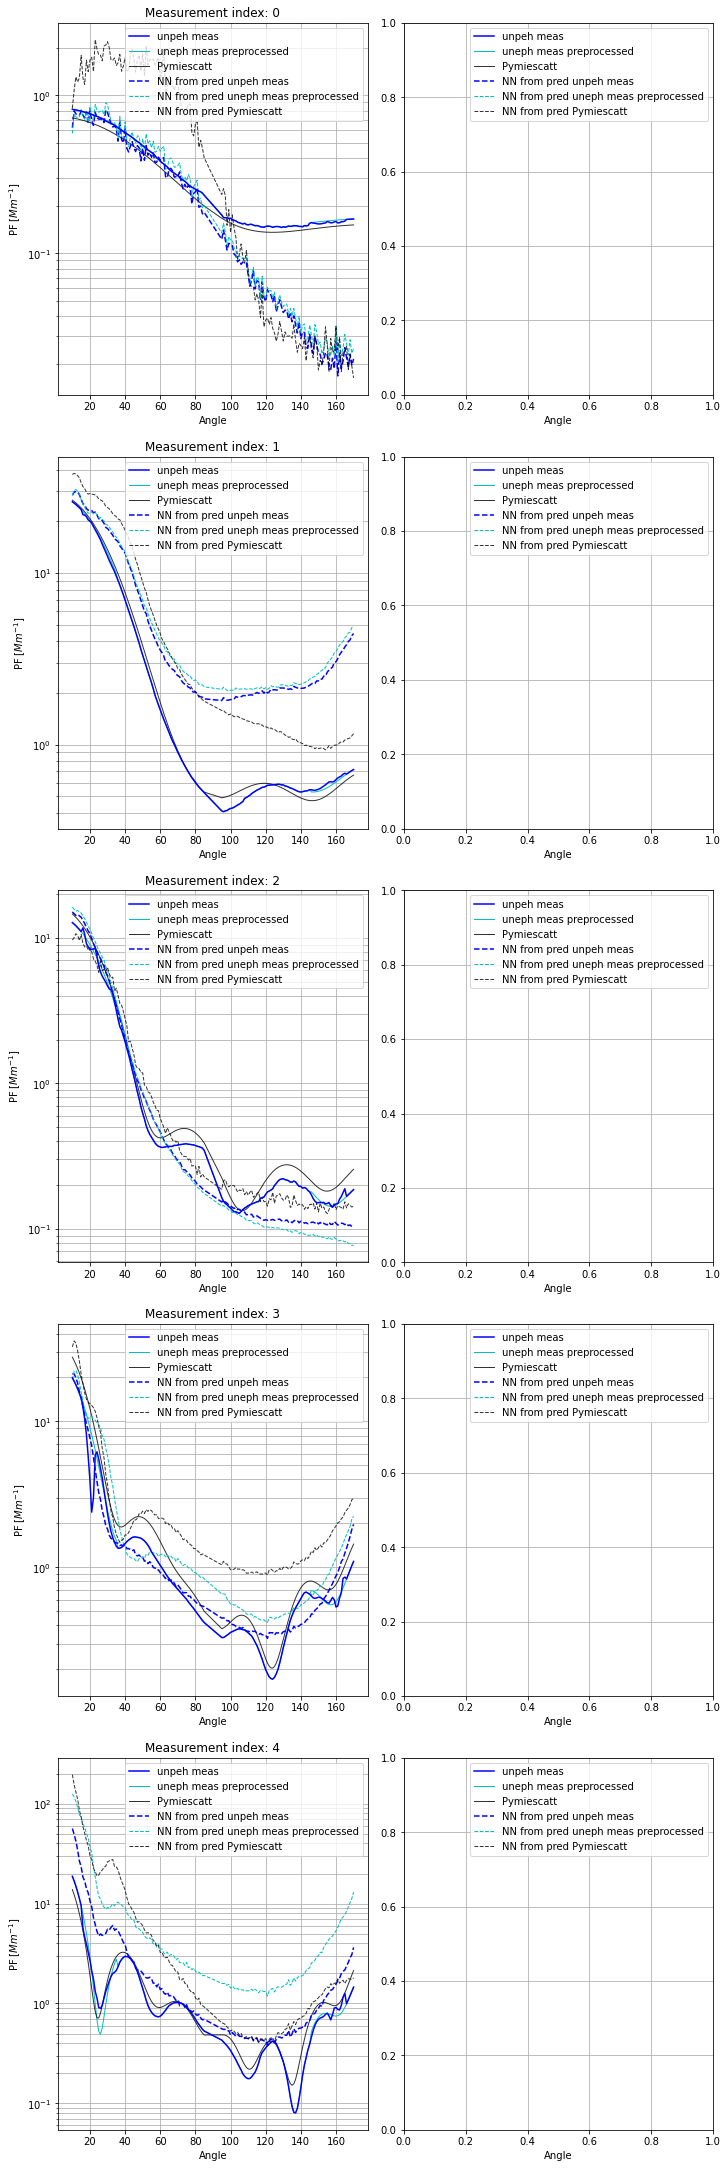

In [31]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 30), constrained_layout=True)
for index in range(5):
    axs[index,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')

    meas_prepro_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')

        
    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')

        
        

        
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred0_4.jpg')


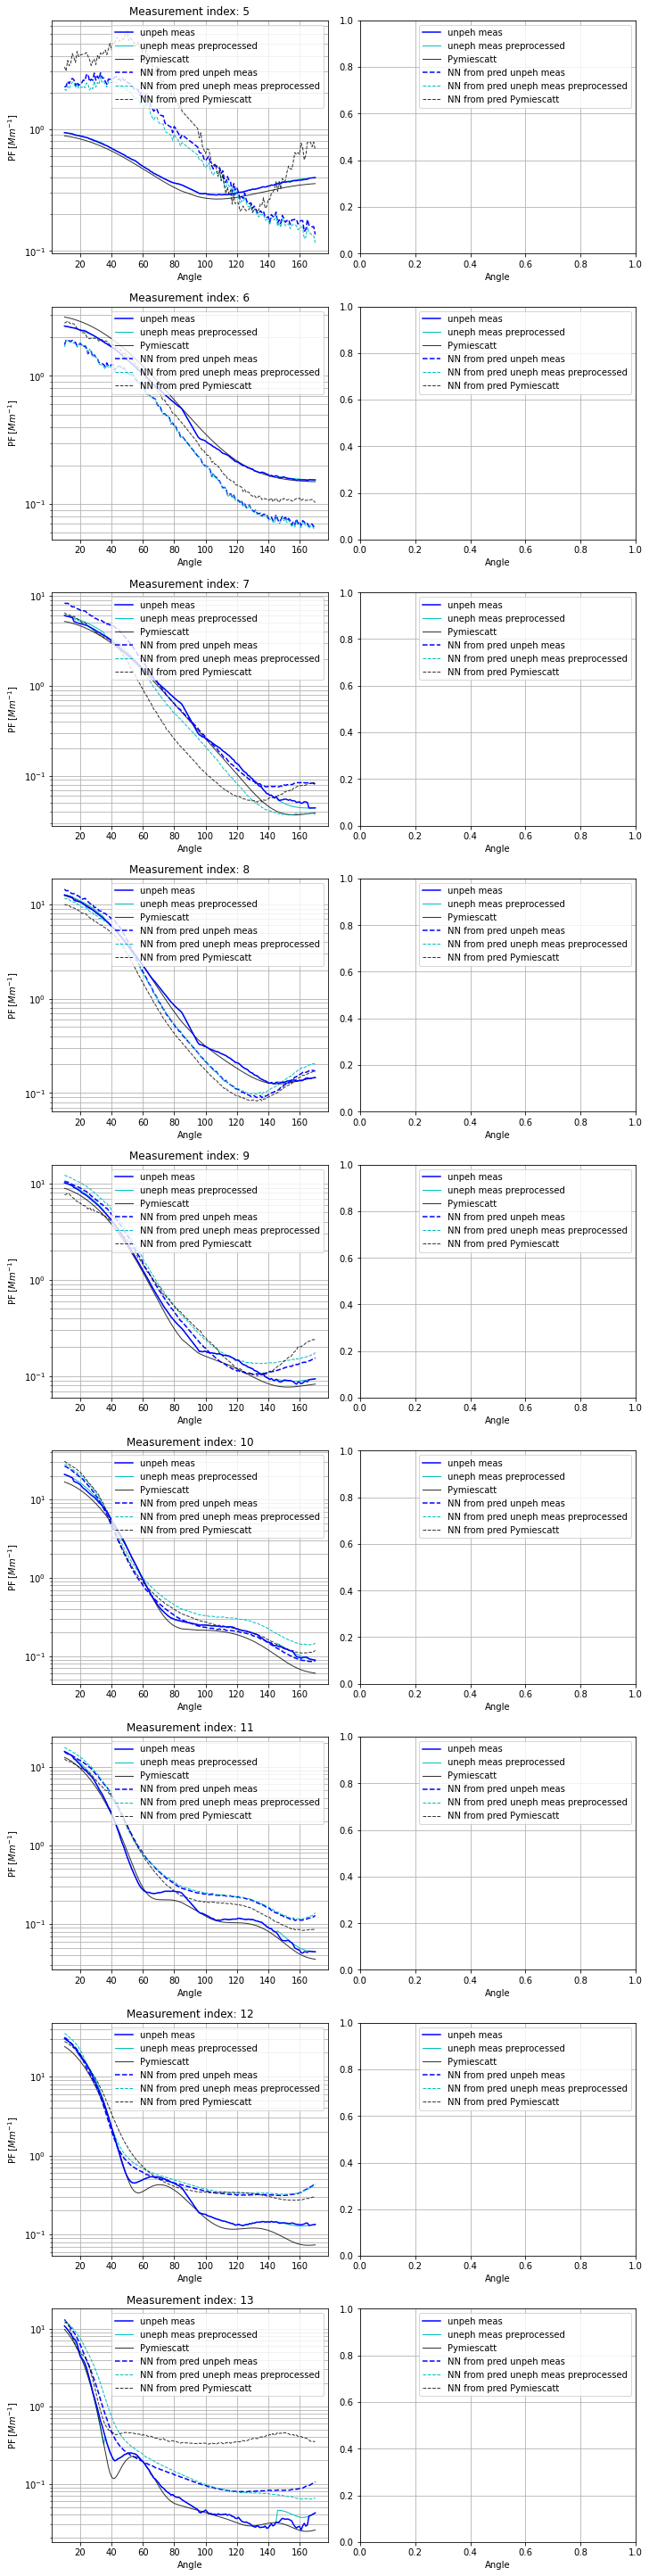

In [32]:

fig, axs = plt.subplots(ncols=2, nrows=9, figsize=(10, 40), constrained_layout=True)
for index in range(5,14):
    axs[index-5,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')

    meas_prepro_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')

        
    meas_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')

        
        

        
    axs[index-5,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index-5,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred5_13.jpg')


# Make predictions with Pymiescatt

In [ ]:
D_array = np.logspace(0.1, 5, 300)

In [ ]:
angles_new = np.arange(10,171)
len(angles_new)

In [ ]:
qoi_list_pms_F11 = []
qoi_list_pms_PPF = []
qoi_list_pms = []
for i in range(10,171):
    qoi_list_pms.append('F11_'+str(i))
    qoi_list_pms_F11.append('F11_'+str(i))
for i in range(10,171):
    qoi_list_pms.append('PPF_'+str(i))
    qoi_list_pms_PPF.append('PPF_'+str(i))


In [ ]:
# qoi with Pymiescatt: prediction of measurement data
pms_qoi_meas_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
#pms_qoi_meas_pred.loc[index]=np.concatenate([pms_hdf['F11'].T.values,pms_hdf['PPF'].T.values])
pms_qoi_meas_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pred.csv') 

In [ ]:

# qoi with Pymiescatt: prediction of processed measurement data
pms_qoi_meas_preprocessed_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_preprocessed_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/pms_qoi_meas_preprocessed_pred.csv') 

In [ ]:
# qoi with Pymiescatt: prediction of with pymiescatt predicted measurement data
pms_qoi_meas_pymiescatt_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pymiescatt_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pymiescatt_pred.csv') 

In [33]:
# Calculate relative error for aerosol retrieval

def rel_error(true, pred):
    relative_error = np.abs(true-pred)/np.abs(true)*100
    return relative_error
relerr1 = rel_error(dvar_meas, dvar_meas_pred)
print(relerr1.mean())
relerr2 = rel_error(dvar_meas, dvar_meas_preprocessed_pred)
print(relerr2.mean())
relerr3 = rel_error(dvar_meas, dvar_meas_pymiescatt_pred)
print(relerr3.mean())

qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')
qoi_meas[F11_list] = np.exp(qoi_meas[F11_list])
qoi_pred[F11_list] = np.exp(qoi_pred[F11_list])
qoi_meas_pred[F11_list] = np.exp(qoi_meas_pred[F11_list])
qoi_meas_preprocessed_pred[F11_list] = np.exp(qoi_meas_preprocessed_pred[F11_list])
qoi_meas_pymiescatt_pred[F11_list] = np.exp(qoi_meas_pymiescatt_pred[F11_list])
relerr4 = rel_error(qoi_meas, qoi_pred)
relerr5 = rel_error(qoi_meas, qoi_meas_pred)
relerr6 = rel_error(qoi_meas, qoi_meas_preprocessed_pred)
relerr7 = rel_error(qoi_meas, qoi_meas_pymiescatt_pred)
rel_error_df_iv0_4 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv0_4.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[0:4].mean(), relerr1['RmedianV'].loc[0:4].mean(), relerr1['GSD'].loc[0:4].mean(), relerr1['n'].loc[0:4].mean(), relerr1['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[0:4].mean(), relerr2['RmedianV'].loc[0:4].mean(), relerr2['GSD'].loc[0:4].mean(), relerr2['n'].loc[0:4].mean(), relerr2['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[0:4].mean(), relerr3['RmedianV'].loc[0:4].mean(), relerr3['GSD'].loc[0:4].mean(), relerr3['n'].loc[0:4].mean(), relerr3['k'].loc[0:4].mean()]
rel_error_df_iv0_4 = np.round(rel_error_df_iv0_4, decimals = 2)
rel_error_df_iv0_4
rel_error_df_iv5_13 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv5_13.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[5:13].mean(), relerr1['RmedianV'].loc[5:13].mean(), relerr1['GSD'].loc[5:13].mean(), relerr1['n'].loc[5:13].mean(), relerr1['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[5:13].mean(), relerr2['RmedianV'].loc[5:13].mean(), relerr2['GSD'].loc[5:13].mean(), relerr2['n'].loc[5:13].loc[5:13].mean(), relerr2['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[5:13].mean(), relerr3['RmedianV'].loc[5:13].mean(), relerr3['GSD'].loc[5:13].mean(), relerr3['n'].loc[5:13].mean(), relerr3['k'].loc[5:13].mean()]
rel_error_df_iv5_13 = np.round(rel_error_df_iv5_13, decimals = 2)
rel_error_df_iv5_13

rel_error_df_fw0_4 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw0_4.loc['meas_vs_pred'] = [relerr4[F11_list].loc[0:4].mean().mean(),relerr4[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[0:4].mean().mean(),relerr5[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[0:4].mean().mean(),relerr6[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[0:4].mean().mean(),relerr7[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4 = np.round(rel_error_df_fw0_4, decimals = 2)
rel_error_df_fw0_4

rel_error_df_fw5_13 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw5_13.loc['meas_vs_pred'] = [relerr4[F11_list].loc[5:13].mean().mean(),relerr4[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[5:13].mean().mean(),relerr5[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[5:13].mean().mean(),relerr6[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[5:13].mean().mean(),relerr7[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13 = np.round(rel_error_df_fw5_13, decimals = 2)
rel_error_df_fw5_13
rel_error_df_iv0_4.to_csv(f'{plot_dir}/rel_error_df_iv0_4.csv')
rel_error_df_iv5_13.to_csv(f'{plot_dir}/rel_error_df_iv5_13.csv')
rel_error_df_fw0_4.to_csv(f'{plot_dir}/rel_error_df_fw0_4.csv')
rel_error_df_fw5_13.to_csv(f'{plot_dir}/rel_error_df_fw5_13.csv')

Vtot           59.550695
RmedianV       11.246631
GSD             3.144958
n              12.742218
k           11015.919790
dtype: float64
Vtot           73.825577
RmedianV        9.974062
GSD             1.724777
n              12.739816
k           11329.515615
dtype: float64
Vtot          90.149302
RmedianV      16.514999
GSD            3.417372
n             32.980199
k           9629.947805
dtype: float64


<ipython-input-33-8ee36c1ca767>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')
